In [73]:
'''
Midcap Growth Index – Rules-Based Replication (Development)

'''

import pandas as pd
import numpy as np
import matplotlib as plt

'''  
pulling cleaned data into the notebook 
'''
df = pd.read_csv("bloomberg_data_cleaned.csv")

#set date to datetime object 
df["date"] = pd.to_datetime(df["date"])
df.set_index(["date","ticker"],inplace= True)
pd.set_option('display.float_format', '{:,.4f}'.format)
df.head()

dates = df.index.get_level_values("date").unique()

In [74]:
## Reconstitution Schedule
def get_june_reconstitution_dates(dates):
    dates = pd.to_datetime(pd.Series(dates)).sort_values().unique()
    recon = []
    years = pd.DatetimeIndex(dates).year.unique()
    for year in years:
        june = [d for d in dates if d.year == year and d.month == 6]
        if not june:
            continue

        fridays = [d for d in june if pd.Timestamp(d).weekday() == 4] # Monday=0 ... Friday=4
        if not fridays:
            continue

        fridays = sorted(fridays)
        if len(fridays) >= 4:
            recon.append(fridays[3]) # 4th Friday (0-indexed)
        else:
            recon.append(fridays[-1]) # fallback: last Friday available
    return recon

dates = df.index.get_level_values("date").unique()
recon_dates = get_june_reconstitution_dates(dates)
recon_dates

[Timestamp('2022-06-24 00:00:00'),
 Timestamp('2023-06-23 00:00:00'),
 Timestamp('2024-06-28 00:00:00'),
 Timestamp('2025-06-27 00:00:00')]

In [75]:
'''
Midcap Selection Logic
'''

def select_midcap(snapshot, top_n=1000, midcap_start=200):
    snap = snapshot.dropna(subset=["market_cap"]).copy()
    snap = snap.sort_values("market_cap", ascending=False)
    snap = snap.iloc[:top_n]
    midcap = snap.iloc[midcap_start:]
    return midcap


test_date = dates[0]
snapshot = df.xs(test_date, level="date")
midcap = select_midcap(snapshot)

len(midcap), midcap["market_cap"].median()

(742, 12125.1901)

In [76]:
'''
Computing Growth Probability

Since right now we only have P/B data, we can approximate growth
classification using inverse price-to-book (B/P) mapped into a 
smooth probability via a logistic function.
'''

def compute_growth_probability(midcap, k=5.0):
    pb = midcap["price_to_book"].astype(float)

    #convert P/B to B/P since Russell uses B/P
    bp = np.where((pb > 0 ) & np.isfinite(pb), 1.0 / pb, np.nan)
    bp = pd.Series(bp, index=midcap.index)
    bp = bp.fillna(bp.median()) # to fill empty values (for later computation)

    z = (bp -bp.mean()) / (bp.std(ddof=0) + 1e-12) # z-score for standardization
    z_growth = -z # low B/P -> growth, so now high z_growth -> more growthlike

    #normalizing
    #very neg z_growth -> 0 (value), very pos z_growth -> 1 (growth)
    p = 1 / (1 + np.exp(-k * z_growth)) 

    return pd.Series(p, index=midcap.index, name="p_growth")


p_growth = compute_growth_probability(midcap)
p_growth.describe()



count   742.0000
mean      0.6029
std       0.3870
min       0.0000
25%       0.1676
50%       0.7847
75%       0.9594
max       0.9945
Name: p_growth, dtype: float64

In [77]:
'''
Compute index weights
'''
def compute_index_weights(midcap, p_growth):
    cap = midcap["market_cap"].astype(float).clip(lower=0)
    w_cap = cap / cap.sum()

    w = w_cap * p_growth
    w - w / w.sum()

    return pd.Series(w, index=midcap.index, name="weight")

weights = compute_index_weights(midcap, p_growth)
weights.head(), weights.sum()
weights.sort_values(ascending=False).head(10).sum()
weights 

ticker
APTV   0.0035
AEP    0.0005
SLB    0.0023
KHC    0.0000
CTAS   0.0037
        ...  
DJT    0.0001
ASTS   0.0001
CRS    0.0000
VKTX   0.0000
SMMT   0.0000
Name: weight, Length: 742, dtype: float64

In [22]:
'''
Compute Daily Returns
'''
def compute_price_returns(panel):
    prices = panel["close_price"].unstack("ticker").sort_index() # reformatting df for easy calc
    returns = prices.pct_change().fillna(0.0)
    return returns

returns = compute_price_returns(df)
returns.head()

C:\Users\lovaa_ovuf9q6\AppData\Local\Temp\ipykernel_8428\226019915.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().fillna(0.0)


ticker,A,AA,AAL,AAON,AAPL,ABBV,ABNB,ABT,ACGL,ACHC,...,YETI,YUM,Z,ZBH,ZBRA,ZG,ZION,ZM,ZS,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2022-01-04,-0.0338,-0.0469,0.0144,0.0079,-0.0127,-0.0019,-0.0109,-0.0235,0.0130,0.0010,...,-0.0082,0.0053,-0.0188,0.0101,0.0063,-0.0182,0.0285,-0.0239,-0.0671,-0.0381
2022-01-05,-0.0171,0.0177,-0.0179,-0.0395,-0.0266,0.0053,-0.0501,-0.0045,-0.0117,-0.0244,...,-0.0606,-0.0127,-0.0628,-0.0033,-0.0501,-0.0637,0.0023,-0.0276,-0.0684,-0.0380
2022-01-06,0.0035,-0.0017,-0.0059,0.0063,-0.0167,-0.0047,-0.0154,-0.0001,0.0058,-0.0165,...,0.0046,0.0103,-0.0171,-0.0083,-0.0054,-0.0163,0.0411,0.0083,-0.0081,0.0040
2022-01-07,-0.0266,0.0671,0.0382,-0.0295,0.0010,-0.0026,0.0394,0.0031,0.0047,-0.0266,...,-0.0231,-0.0115,-0.0115,-0.0060,-0.0438,-0.0143,0.0167,-0.0268,0.0051,-0.0291


In [23]:
def backtest_midcap_growth(panel):
    returns = compute_price_returns(panel)
    dates = returns.index
    recon_dates = get_june_reconstitution_dates(dates)

    cur_weights = None
    index_returns = []

    for d in dates:
        if (d in recon_dates) or (cur_weights is None):
            snapshot = panel.xs(d, level="date")
            midcap = select_midcap(snapshot)
            p_growth = compute_growth_probability(midcap)
            cur_weights = compute_index_weights(midcap, p_growth)

        daily_ret = returns.loc[d].reindex(cur_weights.index).fillna(0.0)
        idx_ret = (cur_weights * daily_ret).sum()
        index_returns.append(idx_ret)

    result = pd.DataFrame({"index_return": index_returns}, index=dates)
    result["index_level"] = (1 + result["index_return"]).cumprod() * 100

    return result

In [24]:
index_result = backtest_midcap_growth(df)
index_result.tail()

C:\Users\lovaa_ovuf9q6\AppData\Local\Temp\ipykernel_8428\226019915.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().fillna(0.0)


,index_return,index_level
date,,
2025-12-24,0.0017,115.7996
2025-12-26,0.0001,115.8089
2025-12-29,-0.0023,115.5409
2025-12-30,-0.0019,115.3234
2025-12-31,-0.0068,114.5417


<Axes: title={'center': 'Replicated Midcap Growth Index'}, xlabel='date'>

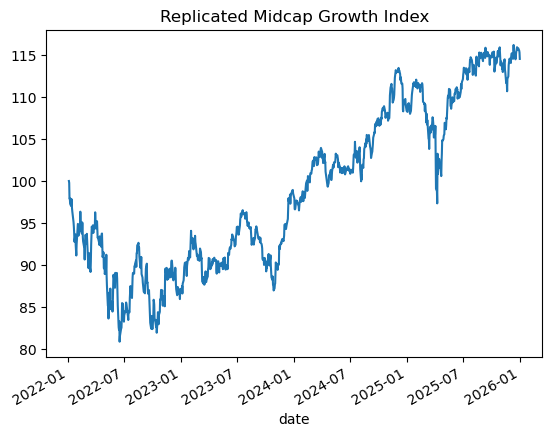

In [25]:
index_result["index_level"].plot(title="Replicated Midcap Growth Index")

In [26]:
## Import RCMG data
import pandas as pd

index_df_real = pd.read_csv("RMCCG_Value.csv")
index_df_real["Date"] = pd.to_datetime(index_df_real["Date"])
index_df_real.set_index("Date",inplace = True)


In [43]:
index_df_real
index_result["index_level"] = index_result["index_level"] * 18.396

In [40]:
index_df_real.iloc[505:,]

,Unnamed: 0,Open,High,Low,Close
Date,,,,,
2022-01-03,250,"1,858.29","1,862.80","1,827.21","1,839.60"
2022-01-04,249,"1,858.29","1,862.80","1,792.52","1,814.66"
2022-01-05,248,"1,812.92","1,812.92","1,742.68","1,742.91"
2022-01-06,247,"1,743.04","1,763.35","1,719.36","1,746.97"
2022-01-07,246,"1,746.51","1,758.23","1,717.26","1,717.35"
...,...,...,...,...,...
2025-12-24,4,"2,251.97","2,262.73","2,247.85","2,258.93"
2025-12-26,3,"2,257.75","2,259.67","2,250.83","2,255.10"
2025-12-29,2,"2,247.98","2,254.97","2,240.56","2,244.77"


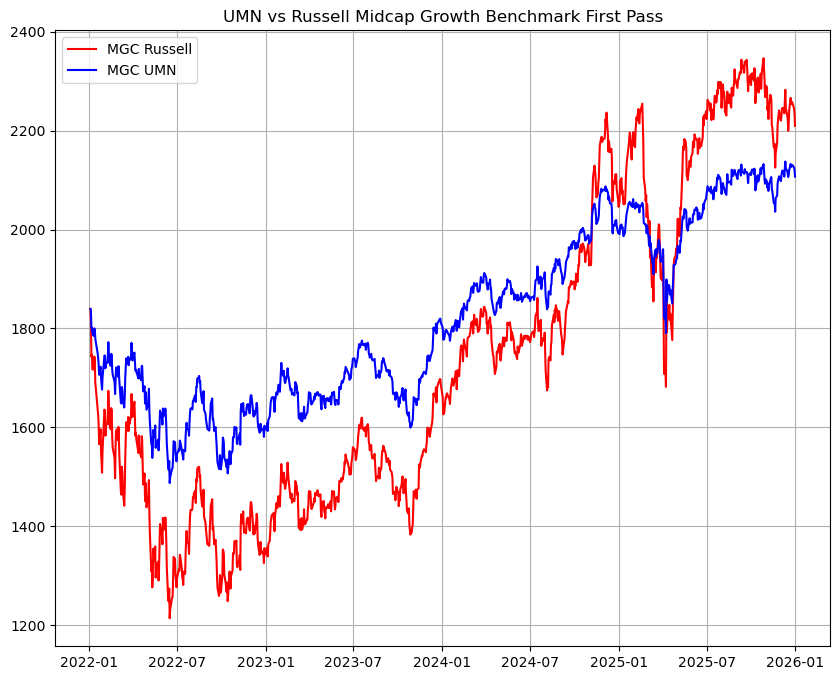

In [72]:
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes

x_data = index_result.index
x_data = index_result.index
y_data_real: pd.Series = index_df_real["Close"].iloc[505:,]
y_data_umn = index_result["index_level"]
y_data_real_clean = y_data_real.str.replace(',', '').astype(float)
y_data_real_clean_clean = pd.to_numeric(y_data_real_clean, errors='coerce').astype(np.float64)

plt.figure(figsize = (10,8))

plt.plot(x_data, y_data_real_clean_clean, label = "MGC Russell", color = "red")
plt.plot(x_data, y_data_umn, label = "MGC UMN", color = "blue")
plt.grid(True)
plt.legend()
plt.title("UMN vs Russell Midcap Growth Benchmark First Pass")
plt.show()




In [63]:
y_data_real = index_df_real["Close"].iloc[505:,]
y_data_real.dtypes

dtype('O')

In [52]:
y_data_umn.dtype

dtype('float64')

In [54]:
type(y_data_real)

pandas.core.series.Series

In [70]:
y_data_real_clean = y_data_real.str.replace(',', '').astype(float)
y_data_real_clean_clean = pd.to_numeric(y_data_real_clean, errors='coerce').astype(np.float64)
